# 1. Installation of packages

In [1]:
#Installation of AutoGluon
!pip3 install -U pip
!pip3 install -U setuptools wheel
!pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip3 install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.17 requires 

In [2]:
#Restating the kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

# 2. Importation of packages and files

In [3]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import gc
from tqdm import tqdm
import autogluon
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error

#Import files from Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/open-problems-multimodal/sample_submission.csv
/kaggle/input/open-problems-multimodal/train_cite_targets.h5
/kaggle/input/open-problems-multimodal/metadata_cite_day_2_donor_27678.csv
/kaggle/input/open-problems-multimodal/test_multi_inputs.h5
/kaggle/input/open-problems-multimodal/evaluation_ids.csv
/kaggle/input/open-problems-multimodal/train_cite_inputs.h5
/kaggle/input/open-problems-multimodal/train_multi_targets.h5
/kaggle/input/open-problems-multimodal/train_multi_inputs.h5
/kaggle/input/open-problems-multimodal/metadata.csv
/kaggle/input/open-problems-multimodal/test_cite_inputs_day_2_donor_27678.h5
/kaggle/input/open-problems-multimodal/test_cite_inputs.h5


# 3. Opening files

In [4]:
df_features = pd.read_hdf("/kaggle/input/open-problems-multimodal/train_cite_inputs.h5")#features_input

In [5]:
df_target = pd.read_hdf("/kaggle/input/open-problems-multimodal/train_cite_targets.h5")#target

# 4. Data Pre-processing

## 4.1. Removing the columns with only 0

In [6]:
#creating a row with the sum of all the columns (each column only has positive values)
df_features.loc['Total']= df_features.sum()

In [7]:
#creating a list with the names of the empty columns
unwanted = [column for column in df_features.columns if df_features[column]["Total"]==0]

In [8]:
#droping the empty columns and the counting row
df_features.drop(unwanted, axis=1, inplace=True)
df_features.drop("Total", inplace=True)

## 4.2. Computing the correlation matrix between our targets and our remaining inputs

In [9]:
a_mat = df_features.to_numpy()
b_mat = df_target.to_numpy()

In [10]:
residuals_a = a_mat - a_mat.mean(axis=0, keepdims=True)#removing the columns' means to each column values
residuals_b = b_mat - b_mat.mean(axis=0, keepdims=True)#removing the columns' means to each column values

In [11]:
a_residual_sums = (residuals_a*residuals_a).sum(axis=0)
b_residual_sums = (residuals_b*residuals_b).sum(axis=0)

In [12]:
residual_products = np.dot(residuals_a.T, residuals_b)

In [13]:
sum_products = np.sqrt(np.outer(a_residual_sums, b_residual_sums))

In [14]:
correlations = residual_products / sum_products

In [15]:
#deleting the unnecessary variables from the RAM
del a_mat
del b_mat
del residuals_a
del residuals_b
del a_residual_sums
del b_residual_sums
del residual_products
del sum_products
gc.collect()

147

<AxesSubplot:>

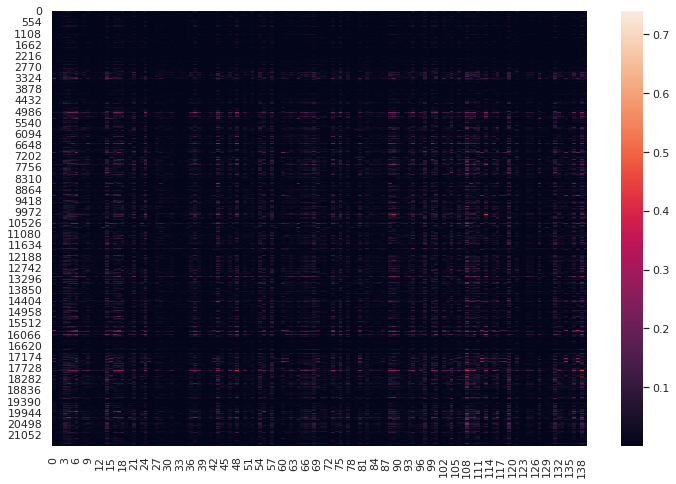

In [16]:
#ploting a heatmap of the correlation
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(np.abs(correlations))

We can see that the heatmap is mostly black but there are few red lines so we decide to keep the best 10 correlated genes for each protein.

## 4.3. Creating the train and test datasets

In [17]:
features_index_2_keep = np.argsort(np.abs(correlations), axis=0)[-10:,:].T#keeping the 10 highest correlated gene for each protein level

In [18]:
metadata = pd.read_csv("/kaggle/input/open-problems-multimodal/metadata.csv")#reading the metadata file 
metadata = metadata[metadata["cell_id"].isin(df_features.index)].drop("technology", axis=1)#keeping the metadata of our citeSeq data and droping useless column

In [19]:
#Creating the train and test dataset based on the dates. Splting on a 80/20 split and keeping the days 2/3 and a part of day 4 on the train set and tesing on the rest.
df_autogluon = metadata.join(df_features, on="cell_id").join(df_target, on="cell_id")
df_autogluon_train_1 = df_autogluon[df_autogluon["day"]<4]
df_autogluon_day_4 = df_autogluon[df_autogluon["day"]==4]
df_autogluon_train_2 = df_autogluon_day_4.sample(n = int(df_autogluon.shape[0]*0.80 - df_autogluon_train_1.shape[0]), random_state=4)
df_autogluon_test = df_autogluon_day_4.drop(df_autogluon_train_2.index)
df_autogluon_train = pd.concat([df_autogluon_train_1, df_autogluon_train_2])

In [20]:
#removing the unecessary variables from the RAM
del df_autogluon
del df_autogluon_train_1
del df_autogluon_day_4
del df_autogluon_train_2
gc.collect()

36

# 5. Creation of the models using AutoGluon

## 5.1. The scoring function

The competition had a special metric: for every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In order to compare our results with other competitors, we use the same metric.

In [21]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

## 5.2. Model training and testing

In [22]:
#list of all the donors
donors = np.unique(df_autogluon_train["donor"])

In [23]:
predicator_list = []

#Creating model with LightGBM, Cat and XGBoost
hyperparameters = {
    'GBM': [
        {}
    ],
    'CAT': {},
    'XGB': {}
}

train_va = []
test_va = []

train_preds = []
test_preds = []

starting_gene = 100
genes_to_predict = 140

for i in tqdm(range(starting_gene, genes_to_predict), desc = 'AutoGluon progress'):
    for donor in donors:
        df_train = df_autogluon_train.loc[df_autogluon_train.index[np.where(df_autogluon_train[["donor"]]==donor)[0]]]
        df_test = df_autogluon_test.loc[df_autogluon_test.index[np.where(df_autogluon_test[["donor"]]==donor)[0]]]
        predicator = TabularPredictor(label=df_target.columns[i], problem_type="regression", eval_metric="pearsonr")
        df_train = df_train[df_features.columns[features_index_2_keep[i]].tolist()+["cell_type"]+[df_target.columns[i]]]
        df_test = df_test[df_features.columns[features_index_2_keep[i]].tolist()+["cell_type"]+[df_target.columns[i]]]
        predicator.fit(df_train, presets='best_quality', hyperparameters=hyperparameters)
        train_va = np.concatenate((train_va, df_train[df_target.columns[i]].to_numpy()), axis=None)
        test_va = np.concatenate((test_va, df_test[df_target.columns[i]].to_numpy()), axis=None)
        train_preds = np.concatenate((train_preds, predicator.predict(df_train)), axis=None)
        test_preds = np.concatenate((test_preds, predicator.predict(df_test)), axis=None)
        predicator_list.append(predicator)
        
train_va = np.reshape(train_va, (genes_to_predict-starting_gene, -1))
test_va = np.reshape(test_va, (genes_to_predict-starting_gene, -1))

train_preds = np.reshape(train_preds, (genes_to_predict-starting_gene, -1))
test_preds = np.reshape(test_preds, (genes_to_predict-starting_gene, -1))

AutoGluon progress:   0%|          | 0/40 [00:00<?, ?it/s]No path specified. Models will be saved in: "AutogluonModels/ag-20221217_173205/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221217_173205/"
AutoGluon Version:  0.6.1
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 10:12:26 UTC 2022
Train Data Rows:    17919
Train Data Columns: 11
Label Column: CD81
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    19757.54 MB
	Train Data (Original)  Memory Usage: 1.8 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fit

No path specified. Models will be saved in: "AutogluonModels/ag-20221217_174311/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221217_174311/"
AutoGluon Version:  0.6.1
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 10:12:26 UTC 2022
Train Data Rows:    19648
Train Data Columns: 11
Label Column: IgD
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    19378.11 MB
	Train Data (Original)  Memory Usage: 1.97 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitt

In [24]:
np.save("train_va.npy", train_va)
np.save("test_va.npy", test_va)

np.save("train_preds.npy", train_preds)
np.save("test_preds.npy", test_preds)

In [25]:
mse_train = mean_squared_error(train_va, train_preds)
corrscore_train = correlation_score(train_va, train_preds)

mse_test = mean_squared_error(test_va, test_preds)
corrscore_test = correlation_score(test_va, test_preds)

## 5.3. Model results

In [26]:
print("The MSE train is:", mse_train)
print("The correlation score train is:", corrscore_train)
print("The MSE test is:", mse_test)
print("The correlation score test is:", corrscore_test)

The MSE train is: 2.905595059008307
The correlation score train is: 0.5113323404192177
The MSE test is: 3.3578244582965113
The correlation score test is: 0.46074124867402233
